In [1]:
import json

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from astropy.visualization import imshow_norm, LinearStretch, ZScaleInterval

%matplotlib inline

In [2]:
def calculate_area(mask_files: list) -> u.Quantity:
    # Read in each mask file and calculate the allowable area
    areas = []
    for mask_file in mask_files:
        mask_img, mask_hdr = fits.getdata(mask_file, header=True)
        mask_wcs = WCS(mask_hdr)

        # Get the area of a pixel in angular units
        pixel_area = mask_wcs.proj_plane_pixel_area()

        # Find the total area of the image by adding all pixels and multiplying by the pixel area
        mask_area = np.count_nonzero(mask_img) * pixel_area
        areas.append(mask_area)

    # Compute total area in sample
    return u.Quantity(areas).sum()

In [3]:
# Read in the color threshold--redshift relations
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color_4.5_17.48.json', 'r') as f:
    sdwfs_purity_data = json.load(f)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')

In [4]:
# Read in the catalogs
sdwfs_iragn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')

In [5]:
# Bin the field by redshift as well
field_bins = np.digitize(sdwfs_iragn['REDSHIFT'], z_bins)
sdwfs_iragn_binned = sdwfs_iragn.group_by(field_bins)

# Get the bin centers
z_bin_centers = np.diff(z_bins) / 2 + z_bins[:-1]

In [6]:
color_threshold = agn_purity_color(0.7)
field_agn = sdwfs_iragn[sdwfs_iragn[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'] >= 0.5]
field_agn_grp = field_agn.group_by('CUTOUT_ID')

cutouts = []
for cutout in field_agn_grp.groups:
    cutout_mask_file = cutout['MASK_NAME'][0]
    cutout_area = calculate_area([cutout_mask_file])

    no_cutout_agn = cutout['COMPLETENESS_CORRECTION'].sum()

    cutout['SURF_DEN'] = no_cutout_agn / cutout_area
    cutouts.append(cutout)
field_agn = vstack(cutouts)

In [9]:
max_cutout_id = field_agn['CUTOUT_ID'][np.argmax(field_agn['SURF_DEN'])]
min_cutout_id = field_agn['CUTOUT_ID'][np.argmin(field_agn['SURF_DEN'])]

max_cutout_cat = field_agn[field_agn['CUTOUT_ID'] == max_cutout_id]
min_cutout_cat = field_agn[field_agn['CUTOUT_ID'] == min_cutout_id]

print(f'{max_cutout_id}: {max_cutout_cat["COMPLETENESS_CORRECTION"].sum()}\t{min_cutout_id}: {min_cutout_cat["COMPLETENESS_CORRECTION"].sum()}')

SDWFS_cutout_093: 23.28121526887612	SDWFS_cutout_081: 2.17172180274207


In [8]:
max_cutout_img, max_cutout_hdr = fits.getdata(f'Data_Repository/Images/Bootes/SDWFS/Cutouts/I1_{field_agn["CUTOUT_ID"][np.argmax(field_agn["SURF_DEN"])]}.fits', header=True)
min_cutout_img, min_cutout_hdr = fits.getdata(f'Data_Repository/Images/Bootes/SDWFS/Cutouts/I1_{field_agn["CUTOUT_ID"][np.argmin(field_agn["SURF_DEN"])]}.fits', header=True)
max_cutout_wcs = WCS(max_cutout_hdr)
min_cutout_wcs = WCS(min_cutout_hdr)

[Text(0.5, 1.0, 'SDWFS_cutout_081')]

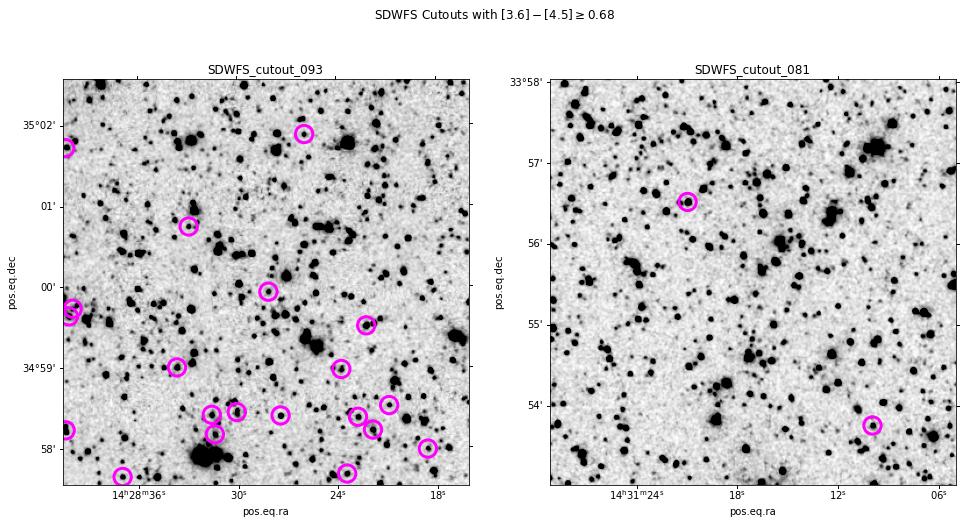

In [13]:
fig = plt.figure(figsize=(16, 8))
max_cutout_ax = fig.add_subplot(121, projection=max_cutout_wcs)
min_cutout_ax = fig.add_subplot(122, projection=min_cutout_wcs)

imshow_norm(max_cutout_img, ax=max_cutout_ax, origin='lower', cmap='Greys', interval=ZScaleInterval(), stretch=LinearStretch())
imshow_norm(min_cutout_img, ax=min_cutout_ax, origin='lower', cmap='Greys', interval=ZScaleInterval(), stretch=LinearStretch())

max_cutout_ax.scatter(max_cutout_cat['ALPHA_J2000'], max_cutout_cat['DELTA_J2000'], marker='o', edgecolor='magenta', facecolor='none', s=300, lw=3, transform=max_cutout_ax.get_transform('world'))
min_cutout_ax.scatter(min_cutout_cat['ALPHA_J2000'], min_cutout_cat['DELTA_J2000'], marker='o', edgecolor='magenta', facecolor='none', s=300, lw=3, transform=min_cutout_ax.get_transform('world'))

fig.suptitle(rf'SDWFS Cutouts with $[3.6] - [4.5] \geq {color_threshold:.2f}$')
max_cutout_ax.set(title=f'{max_cutout_id}')
min_cutout_ax.set(title=f'{min_cutout_id}')